In [2]:
import skimage
from skimage import io
import numpy as np
from PIL import Image
from PIL import ImageDraw
from transformers import pipeline
import easyocr
from sklearn.cluster import DBSCAN

C:\Users\bt0401\anaconda3\envs\ML\lib\site-packages\transformers\utils\generic.py:462: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\bt0401\anaconda3\envs\ML\lib\site-packages\transformers\utils\generic.py:319: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\bt0401\anaconda3\envs\ML\lib\site-packages\transformers\utils\generic.py:319: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\bt0401\anaconda3\envs\ML\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Die angegebene Prozedur wurde nicht gefunden'If you don't plan on using image fun

# Summary
For image detection, we do the following
1. Try to find the error message within an image
2. Find all texts in the image
3. Filter the texts. Only the texts in the error message are relevant. All other texts, we do not care about.

## Step 1: Object recognition: Find Barometer

In [3]:
from transformers import pipeline
# load model for object detection
checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection") #, device='cuda'

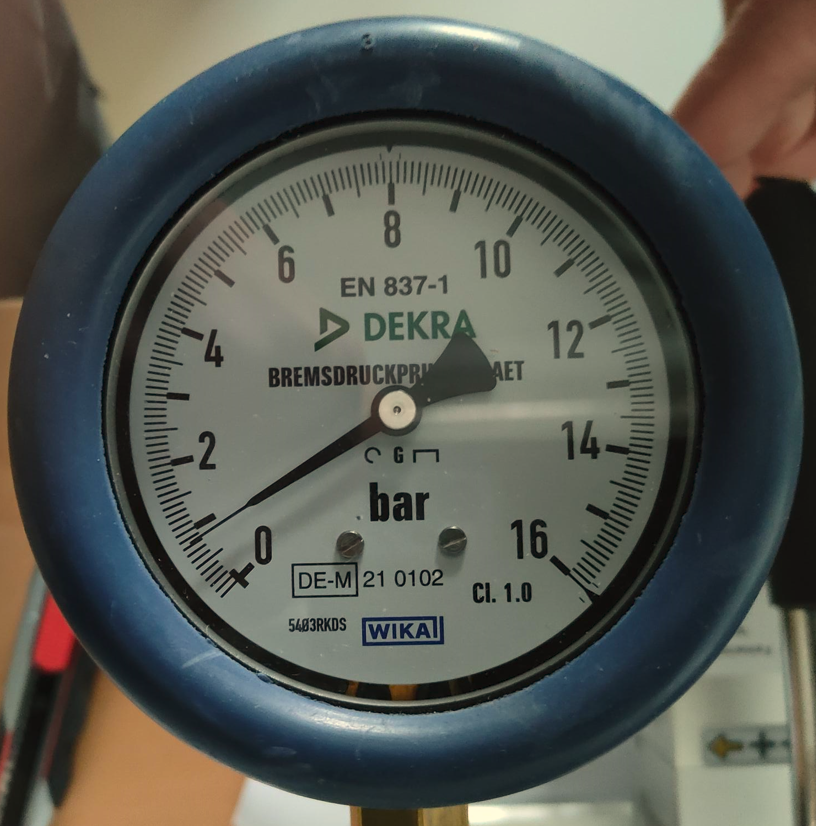

In [11]:
img_path='barometer1.png'

def read_img():
    return Image.fromarray(io.imread(img_path)).convert("RGB")

# print the image
read_img()


In [24]:
# search for specific things in the image
predictions = detector(
    read_img(),
    hypothesis_template="The screenshot shows {}", # similar to "system" prompt in text generation tasks 
    candidate_labels=[ "glass dial of the barometer"], # the is what we are looking for. (purple elefant should not be found)
)
scores = [pred['score'] for pred in predictions]
print(scores)
predictions

[0.37343156337738037, 0.35109612345695496]


[{'score': 0.37343156337738037,
  'label': 'glass dial of the barometer',
  'box': {'xmin': 7, 'ymin': 17, 'xmax': 783, 'ymax': 809}},
 {'score': 0.35109612345695496,
  'label': 'glass dial of the barometer',
  'box': {'xmin': 107, 'ymin': 123, 'xmax': 690, 'ymax': 709}}]

In [25]:
# Using k-means clustering for determining which of the results are the best.
# We use k-means clustering because:
# - we do not know the distribution of our prediction values beforehand (we cannot assume normal distribution for example)
# - we do not know the number of predicitons beforehand
# - we know the number of our clusters k, because presumably, there are 2 groups of predictions: good predictions and bad predictions. Therefore, k=2.


scores_shaped = np.array(scores).reshape(-1, 1)  # reshape for the clustering
# min_samples=1 indicates that a cluster can consist of at least 1 element (score).
# eps=0.05 is the maximum distance between two scores for them to be considered as in the same neighborhood
dbscan = DBSCAN(eps = 0.05, min_samples = 1)
clusters = dbscan.fit_predict(scores_shaped)

# get best scores
highest_cluster = clusters.min()
best_scores = scores_shaped[clusters == highest_cluster]

print(best_scores)

[[0.37343156]
 [0.35109612]]


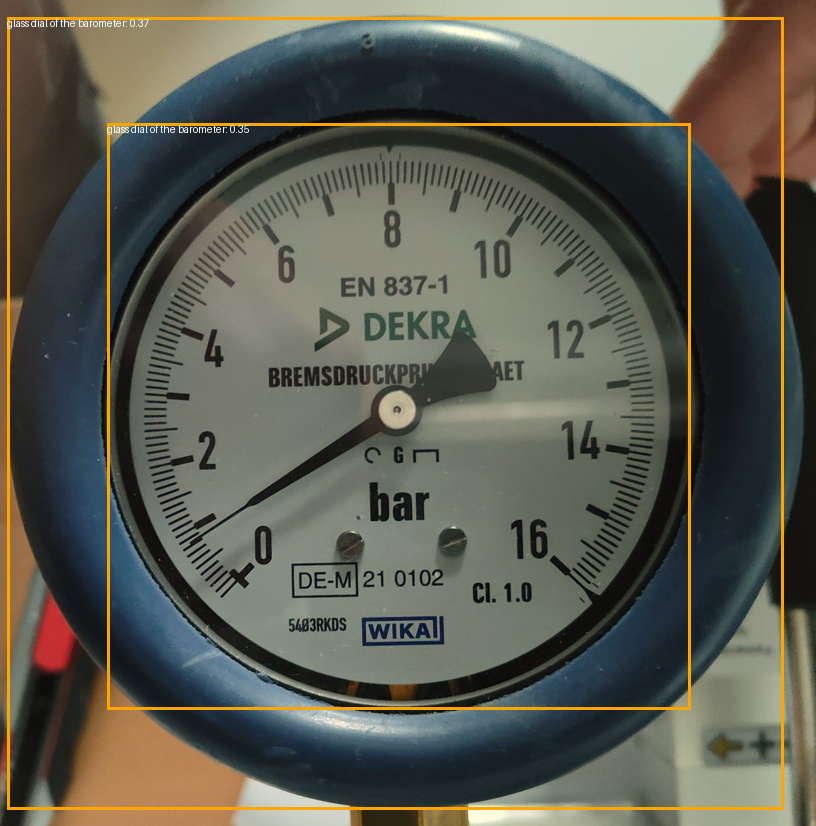

In [26]:
# visualize the predictions in the image
overlay_img = read_img()
draw = ImageDraw.Draw(overlay_img)

def get_bounding_box_for_prediction(n): 
    box = predictions[n]["box"]
    return box.values()

for prediction in predictions[:len(best_scores)]:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]
    xmin, ymin, xmax, ymax = box.values()
    ymiddle = (ymin + ymax) / 2
    xmiddle = (xmin + xmax) / 2
    draw.rectangle((xmin, ymin, xmax, ymax), outline="orange", width=3)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")
    #draw.line((xmiddle, ymin, xmiddle, ymax), fill=(255, 255, 0), width=10)
    #draw.line((xmin, ymiddle, xmax, ymiddle), fill=(255, 255, 0), width=10)

overlay_img